# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='gpu')

In [2]:
import numpy as np
import os
# from scipy.misc import imread, imresize
from skimage.io import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
# from keras import backend as K
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/test.csv').readlines())

train_doc = np.random.permutation(open('../Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('../Project_data/val.csv').readlines())
batch_size = 22 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
print(train_doc)

['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n'
 'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n'
 'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n'
 'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180926_17_06_01_Pro_Stop_new;Stop_new;2\n'
 'WIN_20180907_16_52_18_Pro_Stop Gesture_new;Stop Gesture_new;2\n'
 'WIN_20180907_16_39_19_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180925_17_19_16_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n'
 'WIN_20180907_16_19_10_Pro_Left Swipe_new_Left Swipe_new;Left Swipe_new_Left Swipe_new;0\n'
 'WIN_20180926_16_56_46_Pro

In [7]:
image_name = np.random.permutation(train_doc)[0].split(';')[0]
print(image_name)
sample_img = os.listdir('../Project_data/train'+'//'+image_name)
# sample_image = os.listdir('D:/MS_in_ML_and_AI/Jupyter/Gesture Recognition/datasets/Project_data/train'+'/'+np.random.permutation(train_doc).split(';')[0])

WIN_20180926_17_24_58_Pro_Right_Swipe_new


In [8]:
print(sample_img)

['WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00061.png', 'WIN_20180926_17_24_58_Pro_00049.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00059.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00039.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00021.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00037.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00057.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_P

In [9]:
sample = imread('../Project_data/train'+'/'+image_name+'/'+sample_img[5])

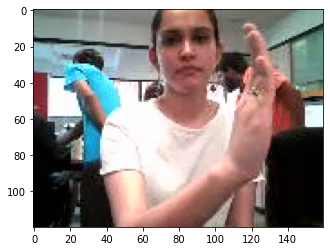

In [10]:
plt.imshow(sample)

In [11]:
# The below code will crop the image from center

def crop_img(image):
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    return image[(height_center-50):(height_center+50), (width_center-50):(width_center+50)]

In [12]:
x = sample
print(x.shape)

x = crop_img(x)
print(x.shape)
print(sample.shape)

(120, 160, 3)
(100, 100, 3)
(120, 160, 3)


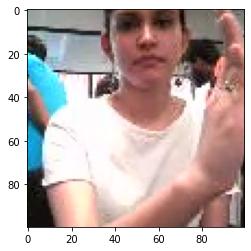

In [13]:
plt.imshow(x)

In [14]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    print('len of folder_list = ', len(folder_list))
    img_idx = range(0,30,3)#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = crop_img(image)
                    image = resize(image,(50,50))
                    image = image/255
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        left_out_img = len(folder_list)%batch_size
        batch+=1
        if left_out_img!=0:
            batch_data = np.zeros((left_out_img,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((left_out_img,5)) # batch_labels is the one hot representation of the output
            for folder in range(left_out_img): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize(image,(50,50))
                    image = image/255
                    batch_data[folder,idx,:,:,0] = image[:,:,0]#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1]#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2]#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [15]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
train_path='../Project_data/train'
val_path='../Project_data/val'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 #50(1st) choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here
num_classes = 5
model = Sequential()

model.add(TimeDistributed(Conv2D(16,(2,2), padding='same'),input_shape=(10,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16,(2,2))))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(32,(2,2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(32,(2,2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(64,(2,2), padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.25))
          
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False, dropout=0.5))
model.add(Dense(128, kernel_regularizer=l2(0.005)))

model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
optimiser = optimizers.SGD()#Adam(1st)write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 50, 50, 16)    208       
_________________________________________________________________
activation (Activation)      (None, 10, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 50, 50, 16)    64        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 49, 49, 16)    1040      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 49, 49, 16)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 49, 49, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 24, 24, 16)    0

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
# print(val_generator))

In [19]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'


checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1,verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
# batch_size=10
# num_epochs=20
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ../Project_data/train ; batch size = 22
len of folder_list =  663


/Users/jain/miniforge3/envs/tf_m1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
31/31 [==============================] - ETA: 0s - loss: 2.4875 - categorical_accuracy: 0.2023Source path =  ../Project_data/val ; batch size = 22
len of folder_list =  100
31/31 [==============================] - 25s 768ms/step - loss: 2.4873 - categorical_accuracy: 0.2030 - val_loss: 2.4601 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model_init_2021-06-2217_35_29.406156/model-00001-2.48076-0.22323-2.46015-0.23000.h5
Epoch 2/40
31/31 [==============================] - 23s 734ms/step - loss: 2.4547 - categorical_accuracy: 0.2451 - val_loss: 2.4700 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model_init_2021-06-2217_35_29.406156/model-00002-2.46200-0.22021-2.46995-0.19000.h5
Epoch 3/40
31/31 [==============================] - 22s 723ms/step - loss: 2.4514 - categorical_accuracy: 0.2386 - val_loss: 2.4575 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2021-06-2217_35_29.406156/model-00003-2.42103-0.27300-2.4

31/31 [==============================] - 23s 738ms/step - loss: 2.0949 - categorical_accuracy: 0.5188 - val_loss: 2.0876 - val_categorical_accuracy: 0.5300

Epoch 00027: saving model to model_init_2021-06-2217_35_29.406156/model-00027-2.09280-0.50528-2.08758-0.53000.h5

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
Epoch 28/40
31/31 [==============================] - 24s 794ms/step - loss: 2.0884 - categorical_accuracy: 0.4684 - val_loss: 2.0742 - val_categorical_accuracy: 0.5100

Epoch 00028: saving model to model_init_2021-06-2217_35_29.406156/model-00028-2.08634-0.48567-2.07417-0.51000.h5
Epoch 29/40
31/31 [==============================] - 23s 744ms/step - loss: 2.1085 - categorical_accuracy: 0.4731 - val_loss: 2.1202 - val_categorical_accuracy: 0.4900

Epoch 00029: saving model to model_init_2021-06-2217_35_29.406156/model-00029-2.11389-0.48115-2.12024-0.49000.h5
Epoch 30/40
31/31 [==============================] - 22s 715ms/step - loss: 2.0766 -

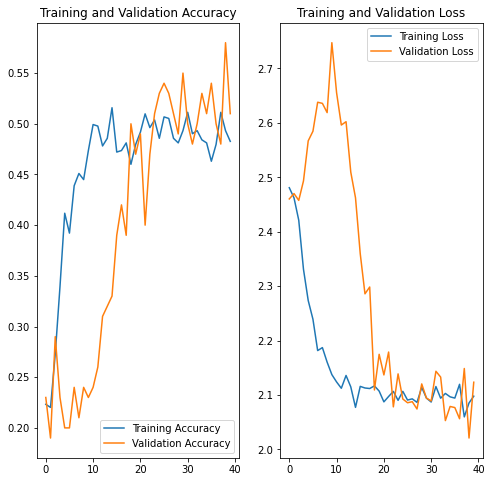

In [22]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()